In [1]:
%matplotlib inline

from __future__ import print_function, division

from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy
import scipy
import scipy.spatial
import pandas
import gensim
import re

In [2]:
def plot_vecs(corpus, query=None, labels=None):
    fig = plt.figure(figsize=(4, 4))
    c = numpy.array(corpus)
    if len(c[0]) == 2:
        ax = plt.gca()
        ax.quiver([0]*len(c),[0]*len(c),c[:,0],c[:,1],angles='xy',scale_units='xy',scale=1)

        if query:
            q = numpy.asarray(query)
            ax.quiver([0],[0],q[0],q[1],angles='xy',scale_units='xy',scale=1, color='r')

        ax.set_xlim([-0.1,c.max()])
        ax.set_ylim([-0.1,c.max()])
    else:
        ax = plt.gca(projection='3d')
        for q in c:
            ax.quiver(0, 0, 0, q[0], q[1], q[2], length=numpy.linalg.norm(q), arrow_length_ratio=0.1, pivot='tail', color='black')

        if query:
            q = numpy.asarray(query)
            ax.quiver(0, 0, 0, q[0], q[1], q[2], length=numpy.linalg.norm(q), arrow_length_ratio=0.1, pivot='tail', color='r')

        ax.set_xlim([0, c.max()])
        ax.set_ylim([0, c.max()])
        ax.set_zlim([0, c.max()])
    lang=labels
    if lang:
        if len(lang) >= 3:
            ax.set_zlabel(lang[2], fontsize=20)
        if len(lang) >= 2:
            ax.set_ylabel(lang[1], fontsize=20)
        if len(lang) >= 1:
            ax.set_xlabel(lang[0], fontsize=20)
    fig.tight_layout()
    plt.show()

# Building Search Engines with Gensim


![tripy](./images/tripython-banner.png)

- PhD candidate @ University of Alabama

- Roll tide 🌀🌊🌀🐘🏈💯

- Search applications for software maintenance tasks
    - Code search
    - Change request triage

- Currently visiting researcher @ ABB
    - Looking for new adventures in 2016!

- Searching through large code bases using more than keyword search
- Searching for developers most apt to handle a bug/issue report

- I have a Twitter ✌️problem✌️
    - I tweet really dumb things sometimes

- I am looking for a job

My advisor says I have a Twitter problem. I love Twitter and treat it seriously and facetiously at the same time. Also, jobs.

These things don't mix well, apparently.

Admitted to being intoxicated and breaking law. Whoops.

Do employers want to hire someone that drinks at noon?

<blockquote class="twitter-tweet" lang="en"><p lang="en" dir="ltr">I was apparently spotted on the local news being a drunk Alabama fan that flooded the streets after the win last night. Whoops.</p>&mdash; christop corley (@excsc) <a href="https://twitter.com/excsc/status/156821367638077440">January 10, 2012</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet" lang="en"><p lang="en" dir="ltr">instead of lunch I am just going to have a bunch of beers and eat pretzels</p>&mdash; christop corley (@excsc) <a href="https://twitter.com/excsc/status/516642590394171393">September 29, 2014</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

**CLARIFICATION: I do not "have a drinking problem", as my mother likes to claim. I am probably actually quite sober right now!* 

# Let's make a search engine

So I have a lot of tweets, lets make a search engine to find all of these bad tweets for deletion

Lots of different methods for making search engines, but mainly two essential behaviors we want

`search("drunk") => [tweets containing the word 'drunk']`

`search("drunk") => [tweets *related* to the word 'drunk']`

In [3]:
import gensim

I'm a `gensim` contributor

`gensim`'s ✌️design✌️ is not always great, certainly better tools exist that can supplement or replace parts of this talk, e.g.:

1. `whoosh`
2. `nltk`
3. `scikit-learn`

OMG WHAT ABOUT GREP?

### `grep` is great, but

- must search through all documents
- not aware of language-specific semantics
- does not rank by relevence

1. First relates to the efficiency (speed): we want results fast!
2. Second relates to the effectiveness (quality): we want to avoid false-positives
3. Third relates to the effectiveness (quality): we want things ordered by relevence

# Basics

1. **Prepare** the corpus
2. **Model** the corpus 
3. **Index** the corpus
4. **Query** fun-time!

These are the basic steps, all of which gensim can help. However, gensim's most powerful features fall out of number 2!

Gensim has some powerful models that can help with many tasks requiring measuring document similarity, not just search.

The model we choose will influence how we prepare and index the corpus.

In [4]:
cat_phrases = ["meow",
               "meow meow meow hiss",
               "meow hiss hiss",
               "hiss"
              ]

Let's pretend we have 4 cats that all have different signature catch phrases.

Now, we need a good way to represent these cats, but in a way a computer can understand easily.

In [5]:
cat_lang = ["meow", "hiss"]

cat_phrase_vectors = [[1, 0],
                      [3, 1],
                      [1, 2],
                      [0, 1]]

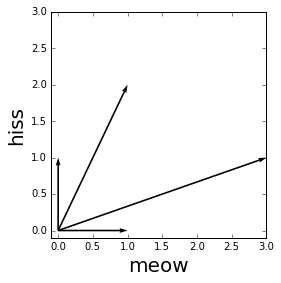

In [6]:
plot_vecs(cat_phrase_vectors, labels=cat_lang)

The vector space model

Assign words to ids of which position in the vector it will be in

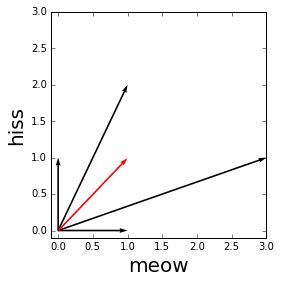

In [7]:
cat_lang = ["meow", "hiss"]

cat_phrase_vectors = [[1, 0],
                      [3, 1],
                      [1, 2],
                      [0, 1]]
other_cat = [1, 1]

plot_vecs(cat_phrase_vectors, other_cat, labels=cat_lang)

In [8]:
for cat in cat_phrase_vectors:
    print("%s =>  %.3f" % (cat, 1 - scipy.spatial.distance.cosine(cat, other_cat)))

[1, 0] =>  0.707
[3, 1] =>  0.894
[1, 2] =>  0.949
[0, 1] =>  0.707


Compare all cats we know about to this other cat

Read the results.

What if we expand our language to include more words?

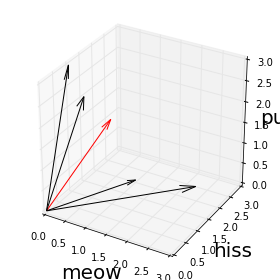

In [9]:
cat_lang3 = ["meow", "hiss", "purr"]

cat_phrase_vectors3 = [[1, 0, 3],
                       [3, 1, 1],
                       [1, 2, 0],
                       [0, 1, 3]]

other_cat3 = [1, 1, 2]

plot_vecs(cat_phrase_vectors3, other_cat3, labels=cat_lang3)  # matplotlib whyyy

This is a very simple example. If we had more than two words in our vocabulary, the dimensionality gets bigger. So, a lot of prep steps are working towards reducing this dimensionality as much as possible.

Imagine if we wanted to build a search engine for Wikipedia? 5 million articles and a kajillion words.

# Preparing the corpus

1. Tokenizing

In [10]:
text = "Jupyter/IPython notebook export to a reveal.js slideshow is pretty cool!"
text.split()

['Jupyter/IPython',
 'notebook',
 'export',
 'to',
 'a',
 'reveal.js',
 'slideshow',
 'is',
 'pretty',
 'cool!']

In [11]:
list(gensim.utils.tokenize(text))

[u'Jupyter',
 u'IPython',
 u'notebook',
 u'export',
 u'to',
 u'a',
 u'reveal',
 u'js',
 u'slideshow',
 u'is',
 u'pretty',
 u'cool']

Gensim has one built-in, but uses a regex that splits on all non-alphabeticals.

Splits on slash, but we also filter out '.' and '!'

## When do we want to tokenize?

In [12]:
list(gensim.utils.tokenize("Jupyter/IPython"))

[u'Jupyter', u'IPython']

In [13]:
list(gensim.utils.tokenize("AC/DC"))

[u'AC', u'DC']

Tokenization is more or less the bare minimum that we need to do to build a VSM.

All other prep steps are for reducing the dimensions as much as possible.

# Preparing the corpus

1. Tokenizing
2. Normalizing

In [14]:
text.lower()

'jupyter/ipython notebook export to a reveal.js slideshow is pretty cool!'

- `"ipython" => "ipython"`
- `"IPython" => "ipython"`
- `"iPython" => "ipython"`

The idea is that no matter the casing, we can collapse 3D into a common one

# When do we want to normalize?

In [15]:
"TriPython".lower()

'tripython'

In [16]:
"Apple".lower()

'apple'

"an apple I am about to eat"
"an apple computer I am about to eat"

This is generally ok, we can hopefully rely on other key words in the phrase such as "computer" or "grapes" to help us out

 # Preparing the corpus

1. Tokenizing
2. Normalizing
3. Stopword removal

In [17]:
' '.join(sorted(gensim.parsing.STOPWORDS))

'a about above across after afterwards again against all almost alone along already also although always am among amongst amoungst amount an and another any anyhow anyone anything anyway anywhere are around as at back be became because become becomes becoming been before beforehand behind being below beside besides between beyond bill both bottom but by call can cannot cant co computer con could couldnt cry de describe detail did didn do does doesn doing don done down due during each eg eight either eleven else elsewhere empty enough etc even ever every everyone everything everywhere except few fifteen fify fill find fire first five for former formerly forty found four from front full further get give go had has hasnt have he hence her here hereafter hereby herein hereupon hers herself him himself his how however hundred i ie if in inc indeed interest into is it its itself just keep kg km last latter latterly least less ltd made make many may me meanwhile might mill mine more moreover 

These words are usually very common, and end up adding noise to our vectors. Little value.

In [18]:
list(gensim.utils.tokenize(text.lower()))

[u'jupyter',
 u'ipython',
 u'notebook',
 u'export',
 u'to',
 u'a',
 u'reveal',
 u'js',
 u'slideshow',
 u'is',
 u'pretty',
 u'cool']

In [19]:
[word for word in gensim.utils.tokenize(text.lower()) if word not in gensim.parsing.STOPWORDS]

[u'jupyter',
 u'ipython',
 u'notebook',
 u'export',
 u'reveal',
 u'js',
 u'slideshow',
 u'pretty',
 u'cool']

We still get the gist of this tweet, it's about IPython slides.

In [20]:
import nltk
nltk.download('stopwords')
' '.join(sorted(nltk.corpus.stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cscorley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


u'a about above after again against all am an and any are as at be because been before being below between both but by can did do does doing don down during each few for from further had has have having he her here hers herself him himself his how i if in into is it its itself just me more most my myself no nor not now of off on once only or other our ours ourselves out over own s same she should so some such t than that the their theirs them themselves then there these they this those through to too under until up very was we were what when where which while who whom why will with you your yours yourself yourselves'

NLTK is good, much more conservative English list. But importantly, has more lists than just English.

# When do we want to remove stop words?

In [21]:
[word for word in "the cat sat on the keyboard".split() if word not in gensim.parsing.STOPWORDS]

['cat', 'sat', 'keyboard']

In [22]:
[word for word in "the beatles were overrated".split() if word not in gensim.parsing.STOPWORDS]

['beatles', 'overrated']

Was he talking about beatles as in bugs being overrated, if so then who cares?

If he was talking about THE beatles, maybe we dont want to hire this guy cause he obviously has no taste

# Preparing the corpus

1. Tokenizing
2. Normalizing
3. Stopword removal
    - Short/Long word removal
    - Words that appear in too many or few documents

In [23]:
[word for word in "the cat sat on the keyboard lllllbbbnnnnnbbbbbbbbbbbbbbbbb".split()
      if len(word) > 2 and len(word) < 30]

['the', 'cat', 'sat', 'the', 'keyboard']

# Preparing the corpus

1. Tokenizing
2. Normalizing
3. Stopword removal
4. Stemming

In [24]:
for word in "the runner ran on the running trail for their runs".split():
    
    stemmed_word = gensim.parsing.stem(word)
    
    if stemmed_word != word:
        print(word, "=>", stemmed_word)

running => run
runs => run


Stemming is about reducing a word to it's root form.

Dropping -ing and -s gives us the same words, just not in very good english

## When do we want to stem words?

In [25]:
gensim.parsing.stem("running")

u'run'

In [26]:
gensim.parsing.stem("jupyter")

u'jupyt'

### Stemming alternative: lemmatization!

In [27]:
gensim.utils.lemmatize("the runner ran on the running trail for their runs",
                       allowed_tags=re.compile(".*"))

['the/DT',
 'runner/NN',
 'run/VB',
 'on/IN',
 'the/DT',
 'run/VB',
 'trail/NN',
 'for/IN',
 'their/PR',
 'run/NN']

In [28]:
gensim.utils.lemmatize("the runner ran on the running trail for their runs")

['runner/NN', 'run/VB', 'run/VB', 'trail/NN', 'run/NN']

Lemmatize uses an external library to something LIKE stemming, and also add parts of speech tagging

This will reduce words like ran to run as a verb, but also adds new dimensions for runs to run as a noun

## Putting it all together

In [29]:
def preprocess(text):
    for word in gensim.utils.tokenize(text.lower()):
        if word not in gensim.parsing.STOPWORDS and len(word) > 1:
            yield word
            
list(preprocess("Jupyter/IPython notebook export to a reveal.js slideshow is pretty cool!"))

[u'jupyter',
 u'ipython',
 u'notebook',
 u'export',
 u'reveal',
 u'js',
 u'slideshow',
 u'pretty',
 u'cool']

I've made some arbitrary choices.

In [30]:
gensim.parsing.preprocess_string("Jupyter/IPython notebook export to a reveal.js slideshow is pretty cool!")

[u'jupyt',
 u'ipython',
 u'notebook',
 u'export',
 u'reveal',
 u'slideshow',
 u'pretti',
 u'cool']

# The corpus

My twitter archive

In [31]:
!head -1 tweets.csv

"tweet_id","in_reply_to_status_id","in_reply_to_user_id","timestamp","source","text","retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp","expanded_urls"


Chose this not because I wanted to subject you to my bad tweets, but because it's small, easy to get and nicely formatted

In [32]:
import csv

class TwitterArchiveCorpus():
    def __init__(self, archive_path):
        self.path = archive_path
        
    def iter_texts(self):
        with open(self.path) as f:
            for row in csv.DictReader(f):
                if (row["retweeted_status_id"] == "" and   # filter retweets
                    not row["text"].startswith("RT @") and
                    row["in_reply_to_status_id"] == "" and # filter replies
                    not row["text"].startswith("@")):
                    
                    yield preprocess(row["text"])

tweets = TwitterArchiveCorpus("tweets.csv")

General gensim pattern for doing corpus reading will use an "iterable container" pattern

I've chosen to ignore retweets and replies. Just look at tweets I wrote.

In [33]:
texts = tweets.iter_texts()

print(list(next(texts)))
print(list(next(texts)))

[u'roll', u'tide', u'roll']
[u'yes', u'yes', u'yes']


In [34]:
!head -3 tweets.csv | awk -F '","' '{print $6}'

text
roll tide roll, y'all.
yes yes yes


What happened to "y'all"? Here's a consequence of some prep steps I chose

# Basics

1. **Prepare** the corpus
2. **Model** the corpus 
3. **Index** the corpus
4. **Query** fun-time!

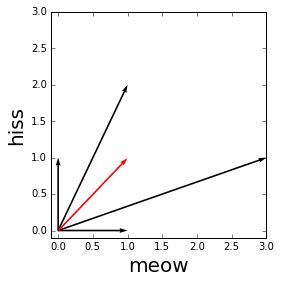

In [35]:
plot_vecs(cat_phrase_vectors, other_cat, labels=cat_lang)

In [36]:
class TwitterArchiveCorpus():
    def __init__(self, archive_path):
        self.path = archive_path
        self.dictionary = gensim.corpora.Dictionary(self.iter_texts())
        
    def iter_texts(self):
        with open(self.path) as f:
            for row in csv.DictReader(f):
                if (row["retweeted_status_id"] == "" and    # filter retweets
                    not row["text"].startswith("RT @") and
                    row["in_reply_to_status_id"] == "" and  # filter replies
                    not row["text"].startswith("@")):
                    
                    yield preprocess(row["text"])
                
    def __iter__(self):
        for document in self.iter_texts():
            yield self.dictionary.doc2bow(document)

    def __len__(self):
        return self.dictionary.num_docs
    
    def get_original(self, key):
        pass  # let's not look at this :-)

tweets = TwitterArchiveCorpus("tweets.csv")

In [37]:
{"meow": 0,
 "hiss": 1,
 "purr": 2}

{'hiss': 1, 'meow': 0, 'purr': 2}

Dictionary will make translating docs into vector space very easy. Goes thru text, creating a mapping of words to ids, counting stats.

bow is "bag of words", or a way to represent docs as sparse vectors

In [38]:
class TwitterArchiveCorpus():
    def __init__(self, archive_path):
        self.path = archive_path
        self.lookup = dict()
        self.dictionary = gensim.corpora.Dictionary(self.iter_texts())
        
    def iter_texts(self):
        current = 0
        with open(self.path) as f:
            for row in csv.DictReader(f):
                if (row["retweeted_status_id"] == "" and   # filter retweets
                    not row["text"].startswith("RT @") and
                    row["in_reply_to_status_id"] == "" and # filter replies
                    not row["text"].startswith("@")):
                    self.lookup[current] = row # BAD BAD BAD
                    current += 1
                    yield preprocess(row["text"])
            
    def __iter__(self):
        for document in self.iter_texts():
            yield self.dictionary.doc2bow(document)
            
    def __len__(self):
        return self.dictionary.num_docs
            
    def get_original(self, key):
        return self.lookup[key]["text"]

    
tweets = TwitterArchiveCorpus("tweets.csv")

In [39]:
vecs = iter(tweets)

print(next(vecs))
print(next(vecs))

[(0, 1), (1, 2)]
[(2, 3)]


In [40]:
texts = tweets.iter_texts()

print(list(next(texts)))
print(list(next(texts)))

[u'roll', u'tide', u'roll']
[u'yes', u'yes', u'yes']


In [41]:
print(tweets.get_original(0))
print(tweets.get_original(1))

roll tide roll, y'all.
yes yes yes


In [42]:
len(tweets), len(tweets.dictionary)

(4411, 9294)

In [43]:
(len(tweets) * len(tweets.dictionary)) / (1024 ** 2)

39.0966739654541

Turns out I don't use a lot of different words, just 9000!

This is why gensim does sparse vectors and generators everywhere! Imagine loading a corpus bigger than this into memory.

# Basics

1. **Prepare** the corpus
2. **Model** the corpus 
3. **Index** the corpus
4. **Query** fun-time!

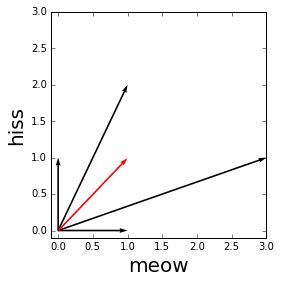

In [44]:
plot_vecs(cat_phrase_vectors, other_cat, labels=cat_lang)

In [45]:
index = gensim.similarities.Similarity('/tmp/tweets',
                                       tweets, 
                                       num_features=len(tweets.dictionary), 
                                       num_best=15)

In [46]:
!ls /tmp/tweets*

/tmp/tweets.0


- prefix= does sharding!
- num_features= because we are using sparse vectors, this gives it a hint of what the max is
- num_best= just tells it to show 15 results (just for presentation purposes)

What does this class do? What kind of indexing

# Basics

1. **Prepare** the corpus
2. **Model** the corpus 
3. **Index** the corpus
4. **Query** fun-time!

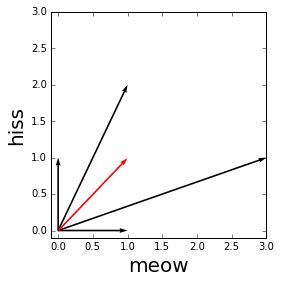

In [47]:
plot_vecs(cat_phrase_vectors, other_cat, labels=cat_lang)

In [48]:
query_bow = tweets.dictionary.doc2bow(preprocess("drunk"))
query_bow

[(1193, 1)]

In [49]:
index[query_bow]

[(275, 0.57735025882720947),
 (2463, 0.57735025882720947),
 (420, 0.44721359014511108),
 (3170, 0.44721359014511108),
 (2530, 0.3333333432674408),
 (3903, 0.31622776389122009),
 (3290, 0.30151134729385376),
 (3928, 0.28867512941360474)]

We gotta translate our query phrase into vector space.

doing getitem on the index will "query" it and give us a document id and it's relatedness to the query

In [50]:
def search(query):
    
    query_bow = tweets.dictionary.doc2bow(preprocess(query))
    
    for doc, percent in index[query_bow]:
        print("%.3f" % percent, "=>", tweets.get_original(doc), "\n")

In [51]:
search("drunk")

0.577 => IEEEtrans.cls is drunk 

0.577 => The university's DNS is drunk 

0.447 => coffee: it's like getting reverse drunk 

0.447 => OH: "Drunk screaming hotdog trivia." 

0.333 => Damn phone typoing names. BTW I AM DRUNK AT A BOY BAND CONCERT 

0.316 => Greatest party theme of the day: Black out in solidarity with internet freedom. #sopa #drunk 

0.302 => The chemistry department that we share a building with has alcohol at events all the time. Why aren't I allowed to get drunk in the lab? 

0.289 => I was apparently spotted on the local news being a drunk Alabama fan that flooded the streets after the win last night. Whoops. 



Point out that shorter tweets are marked as more related! 

When we get more words, the vector changes direction slightly, making it less related!

In [52]:
search("bar")

0.516 => the sports bar I went to watch the game at doesn't even get SEC network what kind of garbage "sports bar" is this 

0.500 => Cashing your check at the bar. #classy 

0.378 => guy at bar next to me just told someone  he once worked 175 hours in one week. lol. 

0.354 => Summertime translation: candy bar &lt;-&gt; corn ear 

0.354 => Current status: Spongebob and Patrick have just entered the Thug Tug bar... 

0.354 => *puts pants on, goes to hotel bar to drink away this game* 

0.354 => Dude next to me at the airport bar is chewing with his mouth open and I just want to scream. 

0.333 => Just saw a bar touchscreen game get rebooted. Apparently this one runs Linux. TIL. 

0.333 => im trying to have a proper gameday in Canada and nobody in this bar knows how to make bloody marys. 

0.302 => Looks like my laundromat/bar crossover idea has already been implemented: http://t.co/x35btduo /cc @o_kimly 

0.289 => Trying to convince myself to go to a health bar and have some health bee

Counter to what I just told you, the first tweet here is actually longer than the others! That's because the word bar appears twice

In [53]:
search("ROLL TIDE")

1.000 => roll tide 

1.000 => roll tide 

1.000 => off side, roll tide 

1.000 => roll tide. 

0.949 => roll tide roll, y'all. 

0.816 => HAHAHAHA ROLL TIDE 

0.816 => roll tide, rain 

0.707 => roll 

0.707 => GRASS FROM BAMA ROLL TIDE 

0.632 => Well ROLL TIDE then http://t.co/1Qg0dPWgqv 

0.535 => Did Kevin just Roll Tide me? Yes, yes he did 

0.500 => introduced myself to the group and got a solid roll tide. Aw yea 

0.426 => Instead of screaming "rolllllllllllll tide roll" we pounce on the string and go "..." because cats don't yell while killing, dummy 

0.392 => sweet home alabama starts playing in detroit during #TBvsDET (because that makes sense) and i get ready for my part to shout 'roll tide' 

0.354 => i also have something that’s like a fruit roll-up, but much less sugary 



# A more slightly more advanced model

In [54]:
lsi = gensim.models.LsiModel(tweets,
                             num_topics=100,
                             power_iters=10,
                             id2word=tweets.dictionary)

power_iters says look at these vectors 10 times

id2word is for other convience methods of the object, has no affect on outcome

In [55]:
len(tweets), len(tweets.dictionary)

(4411, 9294)

In [56]:
len(tweets), lsi.num_topics

(4411, 100)

In [57]:
lsi_index = gensim.similarities.Similarity('/tmp/lsitweets',
                                           lsi[tweets],
                                           num_features=lsi.num_topics,
                                           num_best=15)

In [58]:
def lsi_search(query):
    
    query_bow = tweets.dictionary.doc2bow(preprocess(query))
    
    for doc, percent in lsi_index[lsi[query_bow]]:
        print("%.3f" % percent, "=>", tweets.get_original(doc), "\n")

In [59]:
search("pigpen") # non-LSI search

0.378 => my cats names are bubbie and pigpen. why haven't I been signing off emails with 👨👵🐷? 

0.378 => pigpen really enjoys rolling around on the ground. http://t.co/1se5FPsXnM 



In [60]:
lsi_search("pigpen")

0.975 => my cats names are bubbie and pigpen. why haven't I been signing off emails with 👨👵🐷? 

0.937 => i only interact with #brands if they ask me about my cats first 

0.933 => my cats are currently flipping out about #meowthejewels 

0.923 => the travel tranquilizers I gave my cats made one of them cross-eyed 

0.917 => one of my cats definitely chases her tail 

0.891 => Snapchat videos of my cats meowing as apologies as a service 

0.798 => So I played my unsent Snapchat of my cats being cute as hell during a midterm when I went to view one sent to me 

0.785 => It's always so difficult to sleep in unfamiliar places. But at least there are two cats to keep me company on this couch 

0.768 => update: cats still playing with bug. it's not as dead as I originally thought 

0.746 => Yelling at my cats to go back to bed, it's too early, and take off all that swag you look ridiculous 

0.743 => Instead of screaming "rolllllllllllll tide roll" we pounce on the string and go "..." becaus

# WE NEED TO GO DEEPER *BRRRRRRRAAAAAWWWWRWRRRMRMRMMMMM*

![Deeper](images/gifs/deeper.gif)

## A deep-learning approach

Warning: here be Gensim dragons

gif credit: http://prostheticknowledge.tumblr.com/post/128044261341/implementation-of-a-neural-algorithm-of-artistic

In [61]:
w2v = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',
                                                  binary=True)

### How does "king - man + woman = queen"?

![Vectors](images/gifs/vectors.gif)

gif credit: http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/

In [62]:
def generate_vector_sums():
    for doc in tweets.iter_texts():  # remember me?
        yield gensim.matutils.unitvec(  # DRAGON: hack to make Similarity happy with fullvecs
            sum(
                (w2v[word] for word in doc if word in w2v),
                numpy.zeros(w2v.vector_size)
            )
        )
    
w2v_index = gensim.similarities.Similarity('/tmp/w2v_tweets',
                                           generate_vector_sums(),
                                           num_features=w2v.vector_size,
                                           num_best=15)

In [63]:
def search_w2v(query):
    query_tokens = preprocess(query)
    query_vec = gensim.matutils.unitvec(sum((w2v[word] for word in query_tokens if word in w2v), numpy.zeros(w2v.vector_size)))
    
    for doc, percent in w2v_index[query_vec]:
        print("%.3f" % percent, "=>", tweets.get_original(doc), "\n")

In [64]:
search_w2v("drunk")

0.740 => IEEEtrans.cls is drunk 

0.606 => The university's DNS is drunk 

0.594 => OH: "Drunk screaming hotdog trivia." 

0.542 => coffee: it's like getting reverse drunk 

0.521 => Damn phone typoing names. BTW I AM DRUNK AT A BOY BAND CONCERT 

0.492 => I was apparently spotted on the local news being a drunk Alabama fan that flooded the streets after the win last night. Whoops. 

0.481 => i should be reading papers but instead i am drinking coffee and being pumped about drinking more coffee #coffee 

0.474 => Vim is old enough to drink, y'all. https://t.co/qfZqzlx7Qm 

0.469 => Hey there random anxiety, what an appropriate time to show up. Another beer please, bartender! 

0.469 => Just accidentally killed a job that has been running since April.

Welp, time to drink. 

0.466 => how many red bulls can one drink before 7am?

a lot 

0.463 => Day made by a cyclist cussing out a bro in his truck 

0.452 => damn, someone already beat me to that mango drink name http://t.co/hWzbo3j6de 


In [65]:
search_w2v("kittens")

0.577 => Cat cuddles http://t.co/zPNgmwTqz7 

0.549 => Just saw a bunny while I was walking the dog! Bunnies :) 

0.547 => Snapchat videos of my cats meowing as apologies as a service 

0.518 => Picked my kitty up from being spayed today, and Vet tells me she's not allowed to run or jump. Vet has never had a kitten before, apparently 

0.518 => lap cat is best cat http://t.co/x7ZYkVqbC2 

0.511 => The cat met her after school to walk her home. I wish my cats did that. 

0.511 => I don't see giant roaches often, but when I do, it's because the cats are already on the case #leakyboat http://t.co/QvItKpQFz7 

0.510 => "You are a kitten in a catnip forest" ok http://t.co/XyFNkoW80b 

0.502 => ahh, my kitties! 👨👵🐷💕 

0.500 => A large pool filled with kittens is also acceptable 

0.494 => my cats are currently flipping out about #meowthejewels 

0.489 => actually there are like 5 kittens around that lot 🐱 🐱 🐱 🐱 🐱 

0.488 => Cats really like my feet http://t.co/LuAclUIcTb 

0.488 => someone c

# Thanks for listening! 😻🍻😸

(Is it beer-time yet?)

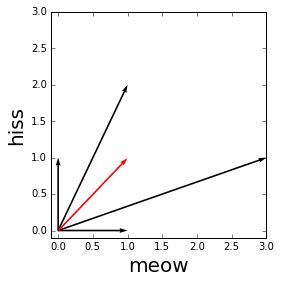

In [66]:
plot_vecs(cat_phrase_vectors, other_cat, labels=["meow", "hiss"])

*No tweets were harmed as a result of this talk. <br /> I am a person; people make mistakes and that's okay.*

### Short-circuiting a full search: inverted index!

In [67]:
cat_lang3 = ["meow", "hiss", "purr"]

cat_phrase_vectors3 = [[1, 0, 3],
                       [3, 1, 1],
                       [1, 2, 0],
                       [0, 1, 3]]

inv_index = defaultdict(set)

for doc_id, doc in enumerate(cat_phrase_vectors3):
    for word_id, freq in enumerate(doc):
        if freq:
            inv_index[word_id].add(doc_id)

In [68]:
inv_index[0]

{0, 1, 2}

In [69]:
inv_index[0].intersection(inv_index[1])

{1, 2}

This is helpful for quickly eliminating measuring similarity for documents where the required keyword never exists.

whoosh has a good one of these!

[Download this notebook](./searching.ipynb)